# Think Bayes

This notebook presents code and exercises from Think Bayes, second edition.

Copyright 2018 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import math
import numpy as np
import pandas as pd

from thinkbayes2 import Pmf, Cdf, Suite, Joint
import thinkplot

### The August birthday problem

This article:

[Attention Deficit–Hyperactivity Disorder and Month of School Enrollment](https://www.nejm.org/doi/10.1056/NEJMoa1806828)

Finds:

>The rate of claims-based ADHD diagnosis among children in states with a September 1 cutoff was 85.1 per 10,000 children (309 cases among 36,319 children; 95% confidence interval [CI], 75.6 to 94.2) among those born in August and 63.6 per 10,000 children (225 cases among 35,353 children; 95% CI, 55.4 to 71.9) among those born in September, an absolute difference of 21.5 per 10,000 children (95% CI, 8.8 to 34.0); the corresponding difference in states without the September 1 cutoff was 8.9 per 10,000 children (95% CI, −14.9 to 20.8). The rate of ADHD treatment was 52.9 per 10,000 children (192 of 36,319 children; 95% CI, 45.4 to 60.3) among those born in August and 40.4 per 10,000 children (143 of 35,353 children; 95% CI, 33.8 to 47.1) among those born in September, an absolute difference of 12.5 per 10,000 children (95% CI, 2.43 to 22.4). These differences were not observed for other month-to-month comparisons, nor were they observed in states with non-September cutoff dates for starting kindergarten. In addition, in states with a September 1 cutoff, no significant differences between August-born and September-born children were observed in rates of asthma, diabetes, or obesity.

And they show this figure:

![](https://www.nejm.org/na101/home/literatum/publisher/mms/journals/content/nejm/2018/nejm_2018.379.issue-22/nejmoa1806828/20181123/images/img_xlarge/nejmoa1806828_f1.jpeg)

However, there is an error in this figure, confirmed by personal correspondence:

>The May and June [diagnoses] are reversed. May should be 317 (not 287) and June should be 287 (not 317).


Based on this corrected data, what can we say about the probability of diagnosis as a function of birth month?

What can we say about the rate of misdiagnosis?

In [12]:
totals = np.array([32690, 31238, 34405, 34565, 34977, 34415, 
                   36577, 36319, 35353, 34405, 31285, 31617])

diagnosed = np.array([265, 280, 307, 312, 317, 287, 
                      320, 309, 225, 240, 232, 243])

array([265, 280, 307, 312, 317, 287, 320, 309, 225, 240, 232, 243])

In [13]:
months = np.arange(1, 13)
rates = diagnosed / totals * 10000
np.round(rates, 1)

array([81.1, 89.6, 89.2, 90.3, 90.6, 83.4, 87.5, 85.1, 63.6, 69.8, 74.2,
       76.9])

In [14]:
rates = np.roll(rates, -8)

array([63.64382089, 69.75730272, 74.15694422, 76.85738685, 81.06454573,
       89.63441962, 89.23121639, 90.26471865, 90.63098608, 83.39386895,
       87.48667195, 85.07943501])

In [15]:
series = pd.Series(rates, index=months)

1     63.643821
2     69.757303
3     74.156944
4     76.857387
5     81.064546
6     89.634420
7     89.231216
8     90.264719
9     90.630986
10    83.393869
11    87.486672
12    85.079435
dtype: float64

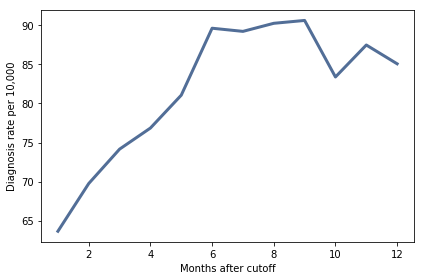

In [16]:
thinkplot.plot(series)
thinkplot.decorate(xlabel='Months after cutoff',
                   ylabel='Diagnosis rate per 10,000')